# U-Net Model Training for Fault Segmentation (keras)

## Step 1: Import Libraries

"First, we import all the necessary libraries. This includes standard libraries like `os` and `numpy`, deep learning libraries from `tensorflow.keras`, and the custom modules `DataGenerator` and `unet` from our project.

In [5]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

# TensorFlow Keras imports
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence, get_custom_objects

from unet3_keras import cross_entropy_balanced
get_custom_objects()['cross_entropy_balanced'] = cross_entropy_balanced

# Set random seeds for reproducibility, as in the original script
np.random.seed(12345)
tf.random.set_seed(1234)

## Step 1a: Verify GPU Availability
This cell checks if TensorFlow can detect a GPU. If a GPU is available, it enables memory growth to prevent TensorFlow from allocating all of the GPU's memory at once.

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        
        # GPU Warm-up to ensure it's ready
        print("Warming up GPU...")
        with tf.device('/GPU:0'):
            dummy_tensor = tf.random.normal([1, 1])
            _ = dummy_tensor * 2.0
        print("GPU is warmed up and ready.")

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU detected. Running on CPU.")

1 Physical GPUs, 1 Logical GPUs
Warming up GPU...
GPU is warmed up and ready.


I0000 00:00:1753759266.662900  159926 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21746 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:41:00.0, compute capability: 8.6


## Step 2: Define Paths and Parameters

In [7]:
# --- Base Directory (!!! IMPORTANT: UPDATE THIS PATH !!!) ---
# Replace this with the absolute path to your project folder
base_dir = "/home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras" # e.g., "/home/user/fault_segmentation"

# --- Source Data Paths ---
# These should point to your original .dat files
original_data_dir = os.path.join(base_dir, "data_from_Wu")
train_seis_dir = os.path.join(original_data_dir, "train/seis")
train_fault_dir = os.path.join(original_data_dir, "train/fault")
validation_seis_dir = os.path.join(original_data_dir, "validation/seis")
validation_fault_dir = os.path.join(original_data_dir, "validation/fault")

# --- Processed Data Paths ---
# We will convert .dat files to .npy and store them here for faster loading
processed_data_dir = os.path.join(base_dir, "data_processed_npy")
train_dir_new = os.path.join(processed_data_dir, 'train')
validation_dir_new = os.path.join(processed_data_dir, 'validation')

# --- Output Artifact Paths ---
model_dir = os.path.join(base_dir, "model") # Changed from 'check1' to avoid conflict
log_dir = os.path.join(base_dir, "logs_keras")
checkpoint_dir = os.path.join(model_dir, "checkpoints")

In [8]:
# --- Training Parameters (from train_keras.py) ---
params = {
    'batch_size': 1,
    'dim': (128, 128, 128),
    'n_channels': 1,
    'shuffle': True
}


In [9]:
# Training configuration
epochs = 10 # Original script uses 100 epochs
learning_rate = 1e-4

## Step 3: Prepare Data

This step involves converting the original `.dat` files into the `.npy` format that our `DataGenerator` expects. We also split the data into training and validation sets. This is a crucial preprocessing step.

In [10]:
def convert_dat_to_npy():
    """Creates directories and converts .dat files to .npy format."""
    # Clean up old directories for a fresh start
    if os.path.exists(processed_data_dir):
        shutil.rmtree(processed_data_dir)
        print(f"Removed old processed data directory: {processed_data_dir}")
    if os.path.exists(model_dir):
        shutil.rmtree(model_dir)
        print(f"Removed old model directory: {model_dir}")


    # Create new directory structure
    os.makedirs(os.path.join(train_dir_new, 'seis'), exist_ok=True)
    os.makedirs(os.path.join(train_dir_new, 'fault'), exist_ok=True)
    os.makedirs(os.path.join(validation_dir_new, 'seis'), exist_ok=True)
    os.makedirs(os.path.join(validation_dir_new, 'fault'), exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("Created new directory structure for processed data and model artifacts.")

    def process_files(file_list, source_seis, source_fault, dest_dir):
        """Reads .dat, reshapes, and saves as .npy."""
        for filename in file_list:
            # Process seismic data
            seis_dat_path = os.path.join(source_seis, filename)
            seis_npy_path = os.path.join(dest_dir, 'seis', filename.replace('.dat', '.npy'))
            seismic_data = np.fromfile(seis_dat_path, dtype=np.single).reshape(params['dim'])
            np.save(seis_npy_path, seismic_data)

            # Process fault data
            fault_dat_path = os.path.join(source_fault, filename)
            fault_npy_path = os.path.join(dest_dir, 'fault', filename.replace('.dat', '.npy'))
            fault_data = np.fromfile(fault_dat_path, dtype=np.single).reshape(params['dim'])
            np.save(fault_npy_path, fault_data)
        print(f"Processed {len(file_list)} files for {os.path.basename(dest_dir)}.")

    # Get file lists
    train_dat_files = [f for f in os.listdir(train_seis_dir) if f.endswith('.dat')]
    validation_dat_files = [f for f in os.listdir(validation_seis_dir) if f.endswith('.dat')]

    print("\nStarting data conversion...")
    process_files(train_dat_files, train_seis_dir, train_fault_dir, train_dir_new)
    process_files(validation_dat_files, validation_seis_dir, validation_fault_dir, validation_dir_new)
    print("\nData preparation complete. All .dat files converted to .npy.")

# Run the conversion
convert_dat_to_npy()

Removed old processed data directory: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/data_processed_npy
Removed old model directory: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/model
Created new directory structure for processed data and model artifacts.

Starting data conversion...
Processed 200 files for train.
Processed 20 files for validation.

Data preparation complete. All .dat files converted to .npy.


## Step 4: Create Data Generators

Now that our data is in the correct format and location, we can use the `DataGenerator` from `utils.py` to feed it to our model efficiently. We create one generator for the training set and one for the validation set.

In [11]:
class DataGenerator(Sequence):
    'Generates data for a Keras model'
    def __init__(self, dpath, fpath, data_IDs, batch_size, dim, n_channels, shuffle):
        'Initialization'
        super().__init__()
        self.dim = dim
        self.dpath = dpath
        self.fpath = fpath
        self.batch_size = batch_size
        self.data_IDs = data_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generates one batch of data'
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        data_IDs_temp = [self.data_IDs[k] for k in indexes]
        X, Y = self.__data_generation(data_IDs_temp)
        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, data_IDs_temp):
        'Generates data containing batch_size samples with augmentation'
        # The augmentation doubles the batch size
        effective_batch_size = len(data_IDs_temp) * 2
        X = np.empty((effective_batch_size, *self.dim, self.n_channels), dtype=np.single)
        Y = np.empty((effective_batch_size, *self.dim, self.n_channels), dtype=np.single)
        
        for i, ID in enumerate(data_IDs_temp):
            # Load pre-converted .npy files
            gx = np.load(os.path.join(self.dpath, ID + '.npy'))
            fx = np.load(os.path.join(self.fpath, ID + '.npy'))
            
            # Normalize seismic data
            xm = np.mean(gx)
            xs = np.std(gx)
            gx = (gx - xm) / (xs + 1e-8) # Add epsilon to avoid division by zero
            
            # Transpose as in original script
            gx = np.transpose(gx)
            fx = np.transpose(fx)

            gx_reshaped = np.reshape(gx, (*self.dim, self.n_channels))
            fx_reshaped = np.reshape(fx, (*self.dim, self.n_channels))
            
            # Original and flipped data for augmentation
            X[i * 2, ] = gx_reshaped
            Y[i * 2, ] = fx_reshaped
            X[i * 2 + 1, ] = np.flipud(gx_reshaped)
            Y[i * 2 + 1, ] = np.flipud(fx_reshaped)

        return X, Y

# --- Instantiate the Generators ---
seismPathT = os.path.join(train_dir_new, "seis/")
faultPathT = os.path.join(train_dir_new, "fault/")
seismPathV = os.path.join(validation_dir_new, "seis/")
faultPathV = os.path.join(validation_dir_new, "fault/")

train_ID = [os.path.splitext(f)[0] for f in os.listdir(seismPathT)]
valid_ID = [os.path.splitext(f)[0] for f in os.listdir(seismPathV)]

train_generator = DataGenerator(dpath=seismPathT, fpath=faultPathT, data_IDs=train_ID, **params)
valid_generator = DataGenerator(dpath=seismPathV, fpath=faultPathV, data_IDs=valid_ID, **params)

print("Data generators for training and validation have been created.")

Data generators for training and validation have been created.


In [12]:
print(f"Number of training pairs: {len(train_ID)}")
print(f"Number of validation pairs: {len(valid_ID)}")

Number of training pairs: 200
Number of validation pairs: 20


## Step 5: Build and Compile the Model

We will now use the `unet` function from `unet3.py` to build our model architecture. After building it, we compile it with an optimizer, a loss function, and metrics to monitor.

In [13]:
def unet(input_size=(128, 128, 128, 1)):
    """Defines the 3D U-Net model architecture from unet3_keras.py."""
    inputs = Input(input_size)
    
    # Encoder Path
    conv1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv4)

    # Decoder Path
    up5 = concatenate([UpSampling3D(size=(2, 2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling3D(size=(2, 2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling3D(size=(2, 2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv7)

    # Output Layer
    conv8 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[conv8])
    return model

def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`."""
    return tf.convert_to_tensor(x, dtype=dtype)

def cross_entropy_balanced(y_true, y_pred):
    """Custom balanced cross-entropy loss function from unet3_keras.py."""
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred = tf.math.log(y_pred / (1 - y_pred))

    y_true = tf.cast(y_true, tf.float32)
    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)
    beta = count_neg / (count_neg + count_pos)
    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=pos_weight)
    cost = tf.reduce_mean(cost * (1 - beta))
    
    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)

# Build and compile the model
model = unet(input_size=(*params['dim'], params['n_channels']))
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss=cross_entropy_balanced,
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │    442,496 │ conv3d_6[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d       │ (None, 32, 32,    │          0 │ conv3d_7[0][0]    │
│ (UpSampling3D)      │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling3d[0]… │
│ (Concatenate)       │ 32, 192)          │            │ conv3d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 32, 32,    │    331,840 │ concatenate[0][0] │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 32, 32,    │    110,656 │ conv3d_8[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d_1     │ (None, 64, 64,    │          0 │ conv3d_9[0][0]  

 Total params: 1,459,585 (5.57 MB)

 Trainable params: 1,459,585 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Define Callbacks

In [14]:
filepath = os.path.join(checkpoint_dir, "fseg-{epoch:02d}.keras") # <-- FIXED
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')

# TensorBoard callback for logging
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# List of callbacks to pass to the model
callbacks_list = [checkpoint, tensorboard_callback]

print("Callbacks defined. Checkpoints will be saved in the new .keras format.")
print("Starting model training...")

Callbacks defined. Checkpoints will be saved in the new .keras format.
Starting model training...


## Step 7: Train the Model

With everything set up, we can now start training the model using the `fit` method. The training and validation data will be provided through our generators.

In [15]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    verbose=1)

print("\nModel training has been completed.")

Epoch 1/10


I0000 00:00:1753759282.419080  161140 service.cc:152] XLA service 0x75c044122b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753759282.419133  161140 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-07-29 05:21:22.522846: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753759283.154835  161140 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-07-29 05:21:24.148991: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-29 05:21:24.295020: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please i

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6441 - loss: 0.0866

2025-07-29 05:23:17.850669: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-29 05:23:17.999415: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-29 05:23:18.501899: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-29 05:23:18.650763: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-29 05:23:21.376561: E external/local_xla/xla/stream_


Epoch 1: saving model to /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/model/checkpoints/fseg-01.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 529ms/step - accuracy: 0.6443 - loss: 0.0866 - val_accuracy: 0.8355 - val_loss: 0.0671
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7809 - loss: 0.0616
Epoch 2: saving model to /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/model/checkpoints/fseg-02.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 472ms/step - accuracy: 0.7809 - loss: 0.0616 - val_accuracy: 0.8771 - val_loss: 0.0584
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8100 - loss: 0.0537
Epoch 3: saving model to /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/model/checkpoints/fseg-03.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 469ms/step - accuracy: 0.8100 - loss: 0.0537 - val_accuracy: 0.8013 - val_loss: 0.0492
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8343 - loss: 0.0469
Epoch 4: sa

## Step 8: Save the Final Model

After training is complete, we save the final model to the `model` directory for future use.

In [16]:
# Create a unique name for the final model using the .hdf5 extension
now = datetime.now()
date_time = now.strftime("%Y-%m-%d_%H-%M-%S")
num_pairs = len(train_ID)
model_name = f"unet_keras_model_{num_pairs}pairs_{epochs}epochs_{date_time}.keras" # <-- FIXED
model_path = os.path.join(model_dir, model_name)

# Save the model
model.save(model_path)

print(f"The final model has been saved to: {model_path}")

The final model has been saved to: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/model/unet_keras_model_200pairs_10epochs_2025-07-29_05-37-45.keras


## Step 9: Visualize Training History

Finally, we visualize the training and validation accuracy and loss over the epochs. This helps us understand how well the model has learned.

Plotting training history...
History plot saved to: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/model/unet_keras_model_200pairs_10epochs_2025-07-29_05-37-45_history.png


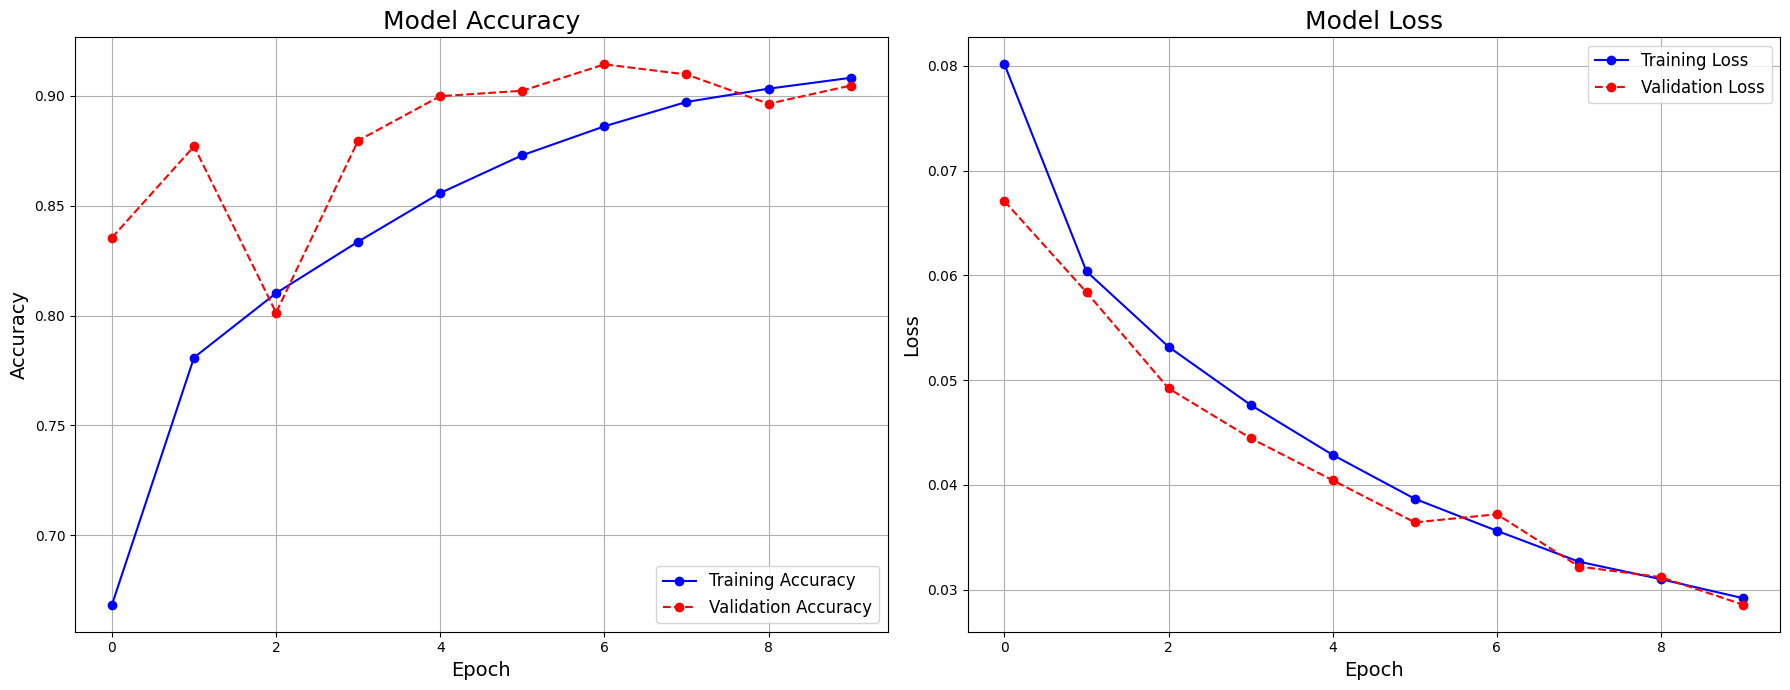

In [17]:
def show_history(history, save_path=None):
    """
    Plots the training and validation accuracy and loss from a Keras history object.
    """
    print("Plotting training history...")
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # --- Plot Accuracy ---
    ax1.plot(history.history['accuracy'], label='Training Accuracy', color='b', marker='o', linestyle='-')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='r', marker='o', linestyle='--')
    ax1.set_title('Model Accuracy', fontsize=18)
    ax1.set_ylabel('Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.legend(loc='lower right', fontsize=12)
    ax1.grid(True)

    # --- Plot Loss ---
    ax2.plot(history.history['loss'], label='Training Loss', color='b', marker='o', linestyle='-')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='r', marker='o', linestyle='--')
    ax2.set_title('Model Loss', fontsize=18)
    ax2.set_ylabel('Loss', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.legend(loc='upper right', fontsize=12)
    ax2.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"History plot saved to: {save_path}")
        
    plt.show()

# Use os.path.splitext to robustly get the model name without its extension
base_name, _ = os.path.splitext(model_name) 

# Create the new plot name
plot_name = f"{base_name}_history.png"
plot_path = os.path.join(model_dir, plot_name)

# Call the function
show_history(history, save_path=plot_path)